## Reading Data

DLTK uses Tensorflow's queueing options to efficiently pass data to the computational graph. Previous versions used a custom wrapper to use generic Python functions and [tf.py_func](https://www.tensorflow.org/api_docs/python/tf/py_func) to pass data to queues. Our current setup makes use of the [tf.data](https://www.tensorflow.org/api_docs/python/tf/data) API that enables us to use TFs wrappers with [tf.data.Dataset.from_generator](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator). We still wrap this function for better stack traces and to provide input functions suitable for [tf.Estimator](https://www.tensorflow.org/api_docs/python/tf/estimator).

In [1]:
from dltk.io.abstract_reader import Reader
help(Reader)

Help on class Reader in module dltk.io.abstract_reader:

class Reader(__builtin__.object)
 |  Wrapper for dataset generation given a read function and a save function
 |  
 |  Methods defined here:
 |  
 |  __init__(self, read_fn, dtypes)
 |      Args:
 |          read_fn: Input function returning features which is a dictionary of
 |      string feature name to `Tensor` or `SparseTensor`. If it returns a
 |      tuple, first item is extracted as features. Prediction continues until
 |      `input_fn` raises an end-of-input exception (`OutOfRangeError` or
 |      `StopIteration`).
 |          dtypes:  A nested structure of tf.DType objects corresponding to each component of an element yielded by generator.
 |  
 |  get_inputs(self, file_references, mode, example_shapes=None, shuffle_cache_size=100, batch_size=4, params=None)
 |      Function to provide the input_fn for a tf.Estimator.
 |      
 |      Args:
 |          file_references: An array like structure that holds the reference to

To build a reader you have to define a read function. This is a function with a signature `read_fn(file_references, mode, params=None)`. Where file_reference is a array_like variable to be used to read files but can also be `None` if not used at all. Mode is a mode key from `tf.estimator.ModeKeys` and params is a dictionary or `None` to pass additional parameters.

In the following cell we define an example reader to read from the IXI dataset you can download with the included script.

In [2]:
import SimpleITK as sitk
import os
from dltk.io.augmentation import *
from dltk.io.preprocessing import *
import tensorflow as tf

def read_fn(file_references, mode, params=None):
    # loop over the list read as csv
    for meta_data in file_references:
        # get the id of the subject to read from the 
        subject_id = meta_data[0]
            
        data_path = '../../data/IXI_HH/1mm'
        
        t1_fn = os.path.join(data_path, '{}/T1_1mm.nii.gz'.format(subject_id))
        
        sitk_t1 = sitk.ReadImage(t1_fn)
        
        t1 = sitk.GetArrayFromImage(sitk_t1)

        # Normalise volume images
        t1 = whitening(t1)
        
        # add channel dimension
        t1 = t1[..., np.newaxis]
        
        # yield image if predict mode (because there is no label present)
        if mode == tf.estimator.ModeKeys.PREDICT:
            # also add the sitk for header information and some metadata - those things are not
            # given to tensorflow because we do not specify a data type for them
            # this can be useful when you want to use the same read function as python generator 
            # for deployment
            yield {'features': {'x': t1}, 'sitk': sitk_t1, 'metadata': {'subject_id': subject_id}}

        # Parse the sex classes from the file_references [1,2] and shift them to [0,1]
        sex = np.int32(meta_data[1]) - 1
        y = sex
            
        # Augment if used in training mode
        if mode == tf.estimator.ModeKeys.TRAIN:
            # here you could to augmentation
            pass
        
        # Check if the reader is supposed to return training examples or full images
        if params['extract_examples']:
            images = extract_random_example_array(t1, example_size=params['example_size'],
                                                  n_examples=params['n_examples'])
            # loop image patches and yield
            for e in range(params['n_examples']):
                yield {'features': {'x': images[e].astype(np.float32)}, 'labels': {'y': y.astype(np.int32)}}
                       
        else:
            yield {'features': {'x': images}, 'labels': {'y': y.astype(np.int32)}}

    return

This can be used as generator in normal Python but we would wrap it with our `Reader` class. You can visualise the examples as follows:

In [3]:
# we use pandas to read csvs that hold meta information to read the files from disk
import pandas as pd
import tensorflow as tf
all_filenames = pd.read_csv( '../../data/IXI_HH/demographic_HH.csv',
                            dtype=object, keep_default_na=False, na_values=[]).as_matrix()

# Set up a data reader to handle the file i/o. 
reader_params = {'n_examples': 1, 'example_size': [128, 224, 224], 'extract_examples': True}

# get a generator for the inputs:
it = read_fn(all_filenames, tf.estimator.ModeKeys.PREDICT, reader_params)

# get example dictionary:
ex_dict = next(it)

np.set_printoptions(edgeitems=1)
print(ex_dict)

{'sitk': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7efcaf928540> >, 'features': {'x': array([[[[-0.7190699],
         ..., 
         [-0.7190699]],

        ..., 
        [[-0.7190699],
         ..., 
         [-0.7190699]]],


       ..., 
       [[[-0.7190699],
         ..., 
         [-0.7190699]],

        ..., 
        [[-0.7190699],
         ..., 
         [-0.7190699]]]], dtype=float32)}, 'metadata': {'subject_id': 'IXI012'}}


We wrap this generator to feed a Tensorflow Dataset. You can generate this queue using our Reader class or do it manually.

In [4]:
reader_example_shapes = {'features': {'x': reader_params['example_size'] + [1,]},
                         'labels': {'y': []}}

reader = Reader(read_fn, {'features': {'x': tf.float32}, 'labels': {'y': tf.int32}})

# Get input functions and queue initialisation hooks for training and validation data
input_fn, qinit_hook = reader.get_inputs(all_filenames,
                                         tf.estimator.ModeKeys.TRAIN,
                                         example_shapes=reader_example_shapes,
                                         batch_size=4,
                                         shuffle_cache_size=10, # define the number of examples held in the queue
                                         params=reader_params)

# the input function splits the dictionary of `read_fn` into features and labels to match the tf.Estimator input
# style. Both are still dictionaries.
features, labels = input_fn()

s = tf.train.MonitoredTrainingSession(hooks=[qinit_hook])

batch_features, batch_labels = s.run([features, labels])


We can visualise the image using matplotlib.

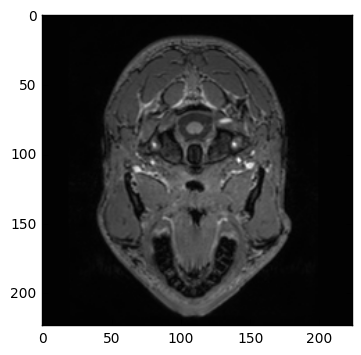

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(batch_features['x'][0, 0, :, :, 0], 'gray')
plt.show()